In [2]:
import nibabel as nb
import numpy as np

import nilearn.plotting as nlp
from nilearn_plotting_custom import plot_surf
import hcp_utils as hcp
from hcp_tools import extract_cortex
from hcp_tools import load_meshes
from analysis import load_data
from hcp_tools import load_flatmaps_59k
from analysis import simple_ridgeCV
from analysis import plot_59k_results
import os
import hrf_tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
from os import walk
import nibabel as nb
import numpy as np
import pandas as pd

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
subject=100610
feature='rms'
n_movies=4

In [4]:
feat_x = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/7T_MOVIE1_CC1_v2_rms.npy')

In [5]:
def load_data(subject,feature,n_movies):
    from sklearn.preprocessing import StandardScaler
    # Inputs: subject = HCP id eg 100610
    #         feature='mfs'
    #         n_movies is a number 1-4
    # Returns: X feature data (2D; time x feature)
    #          Y brain data (2D; time x grayordinate)
    scaler = StandardScaler()
    y_l=[]
    x_l=[]
    stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
    stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
    for i in np.arange(n_movies):
        #load brain image
        im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/{str(subject)}/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
        img = nb.load(im_file)
        img_y = img.get_fdata()
        img_y = scaler.fit_transform(img_y)
        #load feature
        feat_x = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_{feature}.npy')
        feat_x = hrf_tools.apply_optimal_hrf_10hz(feat_x,10)
        feat_x = hrf_tools.resample_1hz(feat_x)
        feat_x = feat_x[:img_y.shape[0],:]
        #feat_x=feat_x.T
        y_l.append(img_y)
        x_l.append(feat_x)
    Y=np.vstack(y_l)
    X=np.vstack(x_l)
    X = scaler.fit_transform(X)
    vertex_info = hcp.get_HCP_vertex_info(img)
    return X,Y,vertex_info

In [6]:
X,Y,vertex_info = load_data(subject,feature,n_movies)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [7]:
X.shape

(3655, 1)

In [8]:
Y.shape

(3655, 170494)

In [9]:
tr=1
n_scans=X.shape[0]

In [10]:
events = pd.DataFrame(columns=['trial_type', 'onset',
                       'duration'])

In [11]:
for i in np.arange(n_scans):
    c_title = 'c'+str(i)
    conditions = [c_title] * n_scans
    duration = np.ones(n_scans)+0.5
    onsets = np.arange(0,n_scans,1)
    df= pd.DataFrame({'trial_type': conditions, 'onset': onsets, 'duration': duration})
    #print(df)
    events.append(df)

In [12]:
events

,trial_type,onset,duration


In [13]:
frame_times= np.arange(n_scans)


In [14]:
frame_times

array([   0,    1,    2, ..., 3652, 3653, 3654])

In [15]:
# from nilearn.glm.first_level import make_first_level_design_matrix
# design_matrices = make_first_level_design_matrix(frame_times, None,
#                           add_regs= X, hrf_model='spm', drift_model=None)

In [124]:
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrices = make_first_level_design_matrix(frame_times, None,
                          add_regs= X, hrf_model='spm')

In [125]:
Y.shape

(3655, 170494)

In [126]:
design_matrices

,reg0,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,drift_9,...,drift_65,drift_66,drift_67,drift_68,drift_69,drift_70,drift_71,drift_72,drift_73,constant
0,-1.044246,0.023392,0.023392,0.023392,0.023392,0.023392,0.023392,0.023392,0.023392,0.023392,...,0.023383,0.023383,0.023383,0.023382,0.023382,0.023382,0.023381,0.023381,0.023381,1.0
1,-1.044246,0.023392,0.023392,0.023392,0.023392,0.023392,0.023392,0.023391,0.023391,0.023391,...,0.023310,0.023308,0.023305,0.023302,0.023300,0.023297,0.023294,0.023291,0.023289,1.0
2,-1.044246,0.023392,0.023392,0.023392,0.023391,0.023391,0.023390,0.023390,0.023389,0.023388,...,0.023164,0.023157,0.023150,0.023143,0.023136,0.023128,0.023120,0.023113,0.023105,1.0
3,-1.044246,0.023392,0.023392,0.023391,0.023391,0.023390,0.023388,0.023387,0.023385,0.023384,...,0.022946,0.022933,0.022919,0.022904,0.022890,0.022875,0.022861,0.022846,0.022830,1.0
4,-1.044246,0.023392,0.023392,0.023391,0.023389,0.023388,0.023386,0.023384,0.023381,0.023378,...,0.022657,0.022634,0.022611,0.022588,0.022564,0.022540,0.022516,0.022491,0.022466,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3650,-1.455334,-0.023392,0.023392,-0.023391,0.023389,-0.023388,0.023386,-0.023384,0.023381,-0.023378,...,-0.022657,0.022634,-0.022611,0.022588,-0.022564,0.022540,-0.022516,0.022491,-0.022466,1.0
3651,-1.435397,-0.023392,0.023392,-0.023391,0.023391,-0.023390,0.023388,-0.023387,0.023385,-0.023384,...,-0.022946,0.022933,-0.022919,0.022904,-0.022890,0.022875,-0.022861,0.022846,-0.022830,1.0
3652,-1.403661,-0.023392,0.023392,-0.023392,0.023391,-0.023391,0.023390,-0.023390,0.023389,-0.023388,...,-0.023164,0.023157,-0.023150,0.023143,-0.023136,0.023128,-0.023120,0.023113,-0.023105,1.0
3653,-1.364386,-0.023392,0.023392,-0.023392,0.023392,-0.023392,0.023392,-0.023391,0.023391,-0.023391,...,-0.023310,0.023308,-0.023305,0.023302,-0.023300,0.023297,-0.023294,0.023291,-0.023289,1.0


<AxesSubplot:label='conditions', ylabel='scan number'>

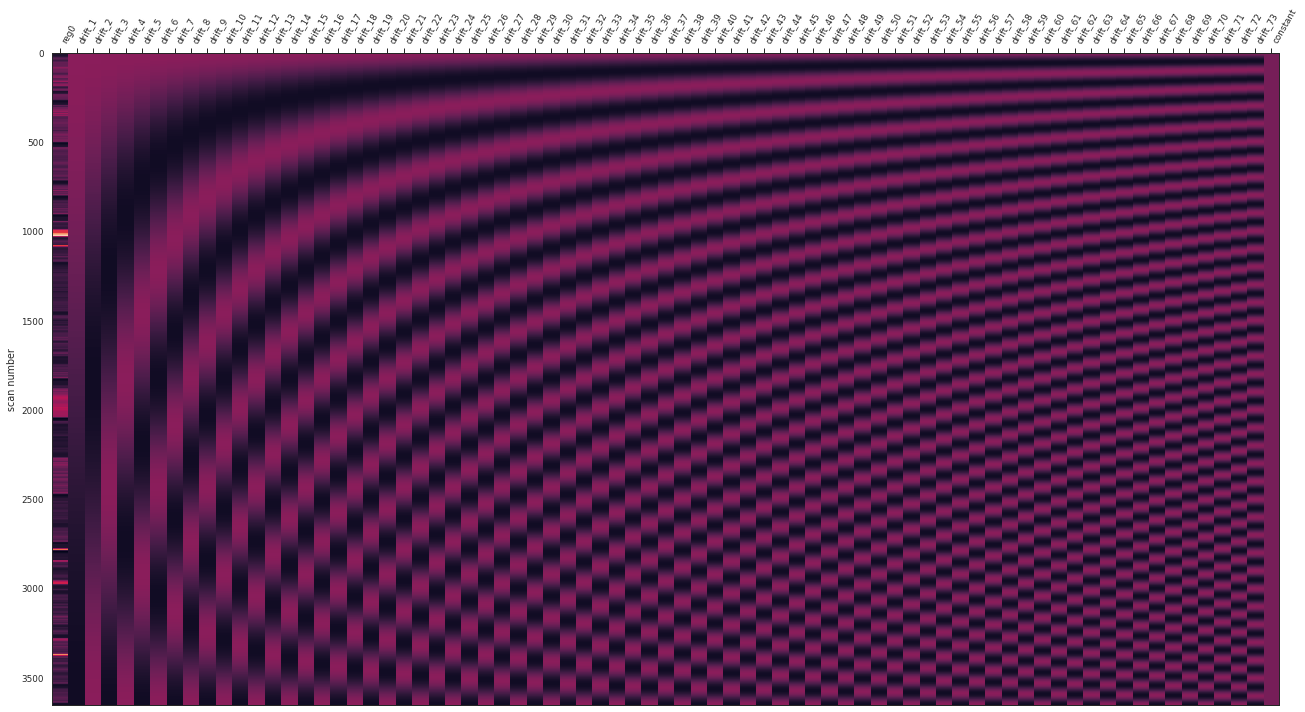

In [129]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrices)

In [ ]:
from nilearn.glm.first_level import run_glm
fmri_glm_labels,fmri_glm_results = run_glm(Y,design_matrices)

In [131]:
from nilearn.glm.contrasts import compute_contrast


In [143]:
contrast_matrix = np.eye(design_matrices.shape[1])
contrast_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [144]:
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrices.columns)])

In [149]:
contrast = compute_contrast(fmri_glm_labels, fmri_glm_results, basic_contrasts['reg0'],contrast_type='t')

TypeError: only size-1 arrays can be converted to Python scalars

In [142]:
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % i out of %i: %s, right hemisphere' %
          (index + 1, len(contrasts), contrast_id))
    # compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    # we present the Z-transform of the t map
    z_score = contrast.z_score()
    # we plot it on the surface, on the inflated fsaverage mesh,
    # together with a suitable background to give an impression
    # of the cortex folding.
    plotting.plot_surf_stat_map(
        fsaverage.infl_right, z_score, hemi='right',
        title=contrast_id, colorbar=True,
        threshold=3., bg_map=fsaverage.sulc_right)

NameError: name 'contrasts' is not defined

In [1]:
contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    # we present the Z-transform of the t map

NameError: name 'compute_contrast' is not defined